# NLP501 - NATURAL LANGUAGE PROCESSING
# LAB 01
## Text Preprocessing & Feature Extraction
## Sentiment Analysis with Logistic Regression

- **Tools:** Python 3.8+, Jupyter Notebook, NLTK, Scikit-learn
- **Dataset:** NLTK Twitter Samples / Custom Dataset

## 2. Chuẩn Bị Môi Trường

### 2.1 Cài đặt thư viện

Mở terminal và chạy các lệnh sau:

```bash
# Tạo virtual environment
python -m venv nlp_env
source nlp_env/bin/activate  # Linux/Mac
nlp_env\Scripts\activate   # Windows

# Cài đặt các thư viện cần thiết
pip install nltk numpy pandas scikit-learn matplotlib seaborn jupyter
```


In [4]:
!pip install nltk

In [2]:
!pip install nltk numpy pandas scikit-learn matplotlib seaborn jupyter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.6 MB/s eta 0:00:00


### 2.2 Download NLTK Data

In [12]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('twitter_samples')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

### 2.3 Kiểm tra cài đặt

In [13]:
import nltk
from nltk.corpus import twitter_samples
from nltk.tokenize import word_tokenize
from sklearn.linear_model import LogisticRegression

# Test
positive_tweets = twitter_samples.strings('positive_tweets.json')
print(f'Loaded {len(positive_tweets)} positive tweets')
print(f'Sample: {positive_tweets[0][:50]}...')


Loaded 5000 positive tweets
Sample: #FollowFriday @France_Inte @PKuchly57 @Milipol_Par...


## 3. Phần 1: Text Preprocessing

### 3.1 Load và khám phá dữ liệu

**Task 1:** Load dữ liệu Twitter và quan sát cấu trúc


In [14]:
import nltk
from nltk.corpus import twitter_samples
import random

# Load positive và negative tweets
positive_tweets = twitter_samples.strings('positive_tweets.json')
negative_tweets = twitter_samples.strings('negative_tweets.json')

print(f'Number of positive tweets: {len(positive_tweets)}')
print(f'Number of negative tweets: {len(negative_tweets)}')

print('\n POSITIVE TWEETS ')
for tweet in positive_tweets[:3]:
    print(f'- {tweet[:80]}...')

print('\n NEGATIVE TWEETS')
for tweet in negative_tweets[:3]:
    print(f'- {tweet[:80]}...')


Number of positive tweets: 5000
Number of negative tweets: 5000

 POSITIVE TWEETS 
- #FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged membe...
- @Lamb2ja Hey James! How odd :/ Please call our Contact Centre on 02392441234 and...
- @DespiteOfficial we had a listen last night :) As You Bleed is an amazing track....

 NEGATIVE TWEETS
- hopeless for tmr :(...
- Everything in the kids section of IKEA is so cute. Shame I'm nearly 19 in 2 mont...
- @Hegelbon That heart sliding into the waste basket. :(...


### 3.2 Xây dựng Preprocessing Pipeline

**Task 2:** Implement các hàm tiền xử lý văn bản


In [15]:
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# NOTE: keep some stopwords for sentiment
stop_words.discard('not')
stop_words.discard('no')
stop_words.discard('nor')
stop_words.discard("won't")
stop_words.discard("wouldn't")
stop_words.discard("couldn't")
stop_words.discard("shouldn't")

def preprocess_tweet(tweet, use_stemming=False):
    '''
    tweet preprocessing.

    Args:
        tweet: string - raw tweet text
        use_stemming: bool - True for stemming, False for lemmatization

    Returns:
        list of tokens after preprocessing
    '''
    # 1. Lowercase
    tweet = tweet.lower()

    # 2. Remove URLs
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet)

    # 3. Remove @mentions
    tweet = re.sub(r'@\w+', '', tweet)

    # 4. Remove hashtag symbol
    tweet = re.sub(r'#', '', tweet)

    # 5. Remove punctuation và special characters
    tweet = re.sub(r'[^a-zA-Z\s]', '', tweet)

    # 6. Tokenize
    tokens = word_tokenize(tweet)

    # 7. Remove stopwords
    tokens = [t for t in tokens if t not in stop_words and len(t) > 1]

    # 8. Stemming or Lemmatization
    if use_stemming:
        tokens = [stemmer.stem(t) for t in tokens]
    else:
        tokens = [lemmatizer.lemmatize(t) for t in tokens]

    return tokens

####  Test preprocessing

In [16]:
sample_tweet = "@user I LOVE this movie!!! It's SO good :) #amazing #best http://example.com"

print('Original:', sample_tweet)
print('Processed:', preprocess_tweet(sample_tweet))


Original: @user I LOVE this movie!!! It's SO good :) #amazing #best http://example.com
Processed: ['love', 'movie', 'good', 'amazing', 'best']


### 3.3 Comparing Stemming vs Lemmatization

**Task 3:** So sánh kết quả của hai phương pháp


In [17]:
test_words = ['running', 'better', 'studies', 'flying', 'happily', 'wolves']

print(f'{"Word":<12} {"Stemmed":<12} {"Lemmatized":<12}')
print('-' * 36)
for word in test_words:
    stemmed = stemmer.stem(word)
    lemmatized = lemmatizer.lemmatize(word)
    print(f'{word:<12} {stemmed:<12} {lemmatized:<12}')


Word         Stemmed      Lemmatized  
------------------------------------
running      run          running     
better       better       better      
studies      studi        study       
flying       fli          flying      
happily      happili      happily     
wolves       wolv         wolf        


## 4. Feature Extraction

### 4.1 Build Vocabulary và Frequency Dictionary

**Task 4:** Xây dựng từ điển tần số từ corpus

In [18]:
from collections import defaultdict

def build_frequency_dict(tweets, labels):
    freq_dict = defaultdict(int)

    for tweet, label in zip(tweets, labels):
        tokens = preprocess_tweet(tweet)
        for token in tokens:
            freq_dict[(token, label)] += 1

    return freq_dict

all_tweets = positive_tweets + negative_tweets
labels = [1] * len(positive_tweets) + [0] * len(negative_tweets)

freq_dict = build_frequency_dict(all_tweets, labels)

print(' Top words in POSITIVE tweets ')
pos_words = [(k[0], v) for k, v in freq_dict.items() if k[1] == 1]
pos_words.sort(key=lambda x: -x[1])
for word, count in pos_words[:10]:
    print(f'{word}: {count}')


 Top words in POSITIVE tweets 
thanks: 392
love: 324
follow: 308
thank: 246
day: 243
im: 241
good: 233
like: 222
happy: 196
get: 174


### 4.2 Feature Extraction: Simple Frequency Features

**Task 5:** Implement feature extraction đơn giản

In [19]:
import numpy as np
def extract_features(tweet, freq_dict):
    '''
    Features:
        - pos_freq: tổng tần số positive của các từ trong tweet
        - neg_freq: tổng tần số negative của các từ trong tweet

    Returns:
        numpy array [pos_freq, neg_freq]
    '''

    tokens = preprocess_tweet(tweet)

    pos_freq = 0
    neg_freq = 0

    for token in tokens:
        pos_freq += freq_dict.get((token, 1), 0)
        neg_freq += freq_dict.get((token, 0), 0)

    return np.array([pos_freq, neg_freq])

# Test
test_tweet = "I love this beautiful day"
features = extract_features(test_tweet, freq_dict)
print(f'Tweet: {test_tweet}')
print(f'Features [pos_freq, neg_freq]: {features}')


Tweet: I love this beautiful day
Features [pos_freq, neg_freq]: [609 296]


### 4.3 Implement TF-IDF

**Task 6:** Implement TF-IDF vectorizer


In [20]:
import math
import numpy as np
from collections import Counter

class SimpleTFIDF:
    def __init__(self):
        self.vocab = {}
        self.idf = {}
        self.num_docs = 0

    def fit(self, documents):
        self.num_docs = len(documents)
        doc_freq = Counter()

        for doc in documents:
            tokens = set(preprocess_tweet(doc))
            for token in tokens:
                doc_freq[token] += 1

        for idx, (word, df) in enumerate(doc_freq.items()):
            self.vocab[word] = idx
            self.idf[word] = math.log(self.num_docs / df)

        print(f'Vocabulary size: {len(self.vocab)}')
        return self

    def transform(self, documents):
        vectors = []
        for doc in documents:
            tokens = preprocess_tweet(doc)
            tf = Counter(tokens)
            total_terms = len(tokens) if tokens else 1

            vector = np.zeros(len(self.vocab))
            for token, count in tf.items():
                if token in self.vocab:
                    tf_val = count / total_terms
                    tfidf_val = tf_val * self.idf[token]
                    vector[self.vocab[token]] = tfidf_val

            vectors.append(vector)

        return np.array(vectors)


#### Test TF-IDF

In [21]:
# Test với small corpus
test_corpus = [
    'I love this movie',
    'This movie is terrible',
    'Great movie, I love it'
]

tfidf = SimpleTFIDF()
tfidf.fit(test_corpus)
vectors = tfidf.transform(test_corpus)

print('Vocabulary:', list(tfidf.vocab.keys()))
print('\nTF-IDF vectors shape:', vectors.shape)
print('\nFirst document vector:')
for word, idx in tfidf.vocab.items():
    if vectors[0][idx] > 0:
        print(f'  {word}: {vectors[0][idx]:.4f}')


Vocabulary size: 4
Vocabulary: ['movie', 'love', 'terrible', 'great']

TF-IDF vectors shape: (3, 4)

First document vector:
  love: 0.2027


## 5. Phần 3: Train Logistic Regression

### 5.1 Chuẩn bị dữ liệu

**Task 7:** Chia train/test và tạo feature matrix


In [22]:
import numpy as np
from sklearn.model_selection import train_test_split

# Tạo dataset
all_tweets = positive_tweets + negative_tweets
labels = np.array([1] * len(positive_tweets) + [0] * len(negative_tweets))

# Shuffle dữ liệu
indices = np.random.permutation(len(all_tweets))
all_tweets = [all_tweets[i] for i in indices]
labels = labels[indices]

# Train/Test split (80/20)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    all_tweets, labels, test_size=0.2, random_state=42
)

print(f'Training set: {len(X_train_raw)} samples')
print(f'Test set: {len(X_test_raw)} samples')


Training set: 8000 samples
Test set: 2000 samples


### 5.2 Phương pháp 1: Simple Frequency Features

In [23]:
# Build frequency dict từ training data only
freq_dict = build_frequency_dict(X_train_raw, y_train)

# Tạo feature matrix
X_train = np.array([extract_features(t, freq_dict) for t in X_train_raw])
X_test = np.array([extract_features(t, freq_dict) for t in X_test_raw])

print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')


X_train shape: (8000, 2)
X_test shape: (2000, 2)


### 5.3 Train Logistic Regression

**Task 8:** Huấn luyện và đánh giá mô hình


In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Train model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Accuracy
print(f'Training Accuracy: {accuracy_score(y_train, y_pred_train):.4f}')
print(f'Test Accuracy: {accuracy_score(y_test, y_pred_test):.4f}')


Training Accuracy: 0.7531
Test Accuracy: 0.7005


### 5.4 Detailed Evaluation

In [25]:
# Classification Report
print('\n CLASSIFICATION REPORT ')
print(classification_report(y_test, y_pred_test, target_names=['Negative', 'Positive']))

# Confusion Matrix
print('\n CONFUSION MATRIX ')
cm = confusion_matrix(y_test, y_pred_test)
print(f'              Predicted')
print(f'              Neg    Pos')
print(f'Actual Neg   {cm[0][0]:4d}   {cm[0][1]:4d}')
print(f'Actual Pos   {cm[1][0]:4d}   {cm[1][1]:4d}')



 CLASSIFICATION REPORT 
              precision    recall  f1-score   support

    Negative       0.68      0.77      0.72      1009
    Positive       0.73      0.63      0.67       991

    accuracy                           0.70      2000
   macro avg       0.70      0.70      0.70      2000
weighted avg       0.70      0.70      0.70      2000


 CONFUSION MATRIX 
              Predicted
              Neg    Pos
Actual Neg    781    228
Actual Pos    371    620


### 5.5 Visualize Confusion Matrix

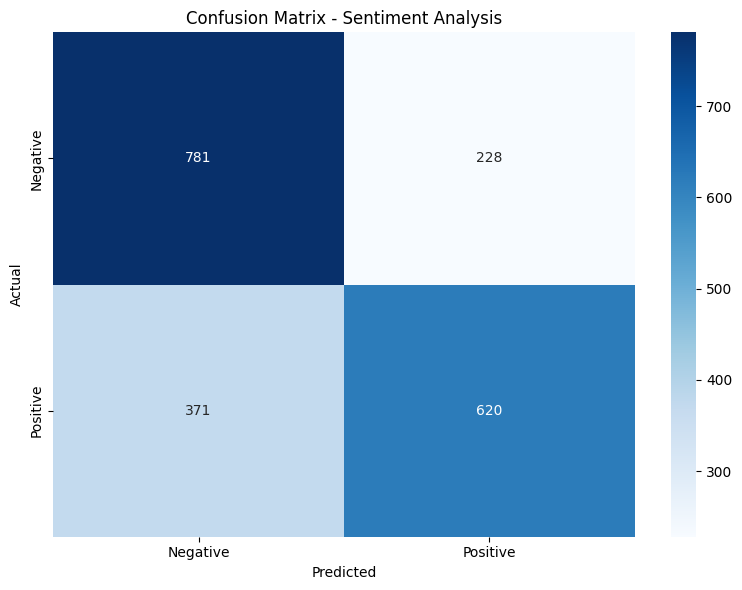

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Sentiment Analysis')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150)
plt.show()

### 5.6 Phân tích Model Parameters

In [28]:
print('Model weights:')
print(f'  w_pos_freq = {model.coef_[0][0]:.6f}')
print(f'  w_neg_freq = {model.coef_[0][1]:.6f}')
print(f'  bias = {model.intercept_[0]:.6f}')

if model.coef_[0][0] > 0:
    print('- Positive frequency có trọng số DƯƠNG -> tăng pos_freq -> tăng P(positive)')
if model.coef_[0][1] < 0:
    print('- Negative frequency có trọng số ÂM -> tăng neg_freq -> giảm P(positive)')


Model weights:
  w_pos_freq = 0.010043
  w_neg_freq = -0.009405
  bias = -0.047259
- Positive frequency có trọng số DƯƠNG -> tăng pos_freq -> tăng P(positive)
- Negative frequency có trọng số ÂM -> tăng neg_freq -> giảm P(positive)


## 6. Phần 4: Error Analysis

### 6.1 Tìm các trường hợp dự đoán sai

**Task 9:** Phân tích các lỗi của mô hình

In [29]:
# Tìm các mẫu dự đoán sai
errors = []
for i in range(len(X_test_raw)):
    if y_pred_test[i] != y_test[i]:
        errors.append({
            'tweet': X_test_raw[i],
            'actual': 'Positive' if y_test[i] == 1 else 'Negative',
            'predicted': 'Positive' if y_pred_test[i] == 1 else 'Negative',
            'features': X_test[i]
        })

print(f'Total errors: {len(errors)} / {len(X_test_raw)} ({100*len(errors)/len(X_test_raw):.1f}%)')

print('\n SAMPLE ERRORS ')
for i, err in enumerate(errors[:10]):
    print(f"\n[{i+1}] Actual: {err['actual']}, Predicted: {err['predicted']}")
    print(f"    Features: pos_freq={err['features'][0]:.0f}, neg_freq={err['features'][1]:.0f}")
    print(f"    Tweet: {err['tweet'][:100]}...")


Total errors: 599 / 2000 (29.9%)

 SAMPLE ERRORS 

[1] Actual: Negative, Predicted: Positive
    Features: pos_freq=642, neg_freq=660
    Tweet: @cIaricestarling i know right... :( i hope it's worth it bc i really wanna see hugh as wolverine aga...

[2] Actual: Positive, Predicted: Negative
    Features: pos_freq=143, neg_freq=277
    Tweet: @Manavparekh @BhaktisBanter pretty but not for a holiday :) #FlipkartFashionFriday...

[3] Actual: Positive, Predicted: Negative
    Features: pos_freq=364, neg_freq=648
    Tweet: *on ma knees* Plz Be Mine @D_diva72: @KingDavid_d1st im unmarried...*checks my finger*...there's no ...

[4] Actual: Positive, Predicted: Negative
    Features: pos_freq=166, neg_freq=322
    Tweet: @TokyoTantra Hahaha tell me anytime you wanna taste it! oh, with yer address to send it :)...

[5] Actual: Positive, Predicted: Negative
    Features: pos_freq=52, neg_freq=95
    Tweet: getting home at 4 waking up at 9 :):)...

[6] Actual: Positive, Predicted: Negative
    F

### 6.2 Phân loại các loại lỗi

In [30]:
# Categorize errors
false_positives = [e for e in errors if e['predicted'] == 'Positive']
false_negatives = [e for e in errors if e['predicted'] == 'Negative']

print(f'False Positives (predicted + but actual -): {len(false_positives)}')
print(f'False Negatives (predicted - but actual +): {len(false_negatives)}')


False Positives (predicted + but actual -): 228
False Negatives (predicted - but actual +): 371


### 6.3 Test với các câu mới

**Task 10:** Test mô hình với dữ liệu mới

In [31]:
def predict_sentiment(tweet, model, freq_dict):
    '''Dự đoán sentiment cho một tweet mới'''
    features = extract_features(tweet, freq_dict).reshape(1, -1)
    pred = model.predict(features)[0]
    prob = model.predict_proba(features)[0]

    sentiment = 'Positive' if pred == 1 else 'Negative'
    confidence = prob[pred]

    return sentiment, confidence

test_sentences = [
    'I absolutely love this product! Best purchase ever!',
    'This is the worst experience I have ever had.',
    'The movie was okay, nothing special.',
    'I am not happy with this service.',
    'Great job, really disappointed...',  # sarcasm
]

print(' PREDICTIONS ')
for sentence in test_sentences:
    sentiment, conf = predict_sentiment(sentence, model, freq_dict)
    print(f'\n"{sentence}"')
    print(f'  -> {sentiment} (confidence: {conf:.2%})')


 PREDICTIONS 

"I absolutely love this product! Best purchase ever!"
  -> Positive (confidence: 87.34%)

"This is the worst experience I have ever had."
  -> Negative (confidence: 54.58%)

"The movie was okay, nothing special."
  -> Negative (confidence: 52.01%)

"I am not happy with this service."
  -> Positive (confidence: 53.44%)

"Great job, really disappointed..."
  -> Positive (confidence: 74.34%)
